**Preprocessing and Modeling on Features Set 1**

Features extracted-

1.Histogram of Oriented Gradients (HOG)

2.Color histogram

3.Haralick texture features


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import graycomatrix, graycoprops
from tqdm import tqdm
import random

In [ ]:
data_dir = 'dataset/dataset_full'

In [ ]:
def resize_and_standardize(image_path, target_size=(150, 150)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
    return img

def normalize_color(img):
    return (img - np.mean(img)) / np.std(img)

def extract_features(img):
    # Histogram of Oriented Gradients (HOG)
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    hog_features = cv2.HOGDescriptor().compute(gray)

    # Color histogram
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 1, 0, 1, 0, 1])
    hist = cv2.normalize(hist, hist).flatten()

    # Haralick texture features
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    glcm = graycomatrix(gray, [1], [0], 256, symmetric=True, normed=True)
    haralick = np.hstack([graycoprops(glcm, prop).ravel() for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']])
    return np.concatenate([hog_features.flatten(), hist, haralick])

#taking only 500 imges from each class
def preprocess_dataset(data_dir, target_size=(150, 150), max_per_class=500):
    X = []
    y = []
    class_names = []

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_names.append(class_name)
            image_paths = [os.path.join(class_path, img_name) for img_name in os.listdir(class_path)
                           if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

            # If it's the Forest class and has more than max_per_class images, randomly sample max_per_class images
            if class_name == 'Forest' and len(image_paths) > max_per_class:
                image_paths = random.sample(image_paths, max_per_class)

            for img_path in tqdm(image_paths, desc=f"Processing {class_name}"):
                img = resize_and_standardize(img_path, target_size)
                img = normalize_color(img)
                features = extract_features(img)
                X.append(features)
                y.append(class_names.index(class_name))

    X = np.array(X)
    y = np.array(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, class_names, scaler



In [ ]:
X_train, X_test, y_train, y_test, class_names, scaler = preprocess_dataset(data_dir)

print("Preprocessed dataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")


Processing Mountains: 100%|██████████| 500/500 [00:03<00:00, 144.79it/s]


Preprocessed dataset shapes:
X_train: (2400, 125257)
X_test: (600, 125257)
y_train: (2400,)
y_test: (600,)
Number of classes: 6
Class names: ['Streets', 'Forest', 'Sea', 'Glacier', 'Building', 'Mountains']


In [ ]:
import joblib
import os

# Directory to save the files
save_dir = "/content/drive/MyDrive/preprocessed_data"
os.makedirs(save_dir, exist_ok=True)

# Save the datasets
joblib.dump(X_train, os.path.join(save_dir, 'X_train.pkl'))
joblib.dump(X_test, os.path.join(save_dir, 'X_test.pkl'))
joblib.dump(y_train, os.path.join(save_dir, 'y_train.pkl'))
joblib.dump(y_test, os.path.join(save_dir, 'y_test.pkl'))
joblib.dump(scaler, os.path.join(save_dir, 'scaler.pkl'))

print("All preprocessed data has been saved successfully.")


All preprocessed data has been saved successfully.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fit PCA to the training data
pca = PCA().fit(X_train)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance
plt.figure(figsize=(6, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=np.argmax(cumulative_explained_variance >= 0.90) + 1, color='r', linestyle='-')
plt.grid()
plt.show()

# Print the number of components needed to explain 90% variance
optimal_components = np.argmax(cumulative_explained_variance >= 0.90) + 1
print(f"Optimal number of components to retain 90% variance: {optimal_components}")


In [ ]:
optimal_components=1199

In [ ]:
# Fit PCA with the optimal number of components
optimal_pca = PCA(n_components=optimal_components)
X_train_pca = optimal_pca.fit_transform(X_train)
X_test_pca = optimal_pca.transform(X_test)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Number of features after PCA: {X_train_pca.shape[1]}")


Original number of features: 125257
Number of features after PCA: 1199


In [ ]:
# Save the PCA-transformed training data
np.save('/content/drive/MyDrive/preprocessed_data/X_train_pca.npy', X_train_pca)
np.save('/content/drive/MyDrive/preprocessed_data/y_train.npy', y_train)

# Save the PCA-transformed test data
np.save('/content/drive/MyDrive/preprocessed_data/X_test_pca.npy', X_test_pca)
np.save('/content/drive/MyDrive/preprocessed_data/y_test.npy', y_test)

# Save the PCA object itself
joblib.dump(optimal_pca, '/content/drive/MyDrive/preprocessed_data/optimal_pca.joblib')

print("PCA-transformed datasets and PCA object have been saved.")

PCA-transformed datasets and PCA object have been saved.


**Random Forest on Feature set 1**

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna
from scipy.stats import randint as sp_randint
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load the PCA-transformed data
X_train_pca = np.load('/content/drive/MyDrive/preprocessed_data/X_train_pca.npy')
y_train = np.load('/content/drive/MyDrive/preprocessed_data/y_train.npy')
X_test_pca = np.load('/content/drive/MyDrive/preprocessed_data/X_test_pca.npy')
y_test = np.load('/content/drive/MyDrive/preprocessed_data/y_test.npy')

# Define the parameter space
param_dist = {
    'n_estimators': sp_randint(100, 500),
    'max_depth': [None] + list(sp_randint(10, 100).rvs(10))
}

# Define the objective function for Optuna
def objective(trial):
    # Sample hyperparameters from the parameter space
    n_estimators = trial.suggest_int('n_estimators', param_dist['n_estimators'].a, param_dist['n_estimators'].b)
    max_depth = trial.suggest_categorical('max_depth', param_dist['max_depth'])

    # Create the Random Forest classifier with the sampled hyperparameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    # Fit the Random Forest classifier
    rf.fit(X_train_pca, y_train)
    # Make predictions on the test set
    y_pred = rf.predict(X_test_pca)
    # Calculate accuracy as the objective value
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the hyperparameters
print("Optimizing hyperparameters using Optuna...")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best hyperparameters:")
print(study.best_params)

[I 2024-06-22 03:48:16,804] A new study created in memory with name: no-name-a0a6449d-f210-4c19-b9b4-b40bbdb870b6


Optimizing hyperparameters using Optuna...


[I 2024-06-22 03:49:20,836] Trial 0 finished with value: 0.5133333333333333 and parameters: {'n_estimators': 473, 'max_depth': 22}. Best is trial 0 with value: 0.5133333333333333.
[I 2024-06-22 03:49:35,747] Trial 1 finished with value: 0.48 and parameters: {'n_estimators': 168, 'max_depth': 22}. Best is trial 0 with value: 0.5133333333333333.
[I 2024-06-22 03:49:49,077] Trial 2 finished with value: 0.485 and parameters: {'n_estimators': 148, 'max_depth': 25}. Best is trial 0 with value: 0.5133333333333333.
[I 2024-06-22 03:50:01,885] Trial 3 finished with value: 0.47333333333333333 and parameters: {'n_estimators': 139, 'max_depth': 99}. Best is trial 0 with value: 0.5133333333333333.
[I 2024-06-22 03:50:44,226] Trial 4 finished with value: 0.505 and parameters: {'n_estimators': 494, 'max_depth': 17}. Best is trial 0 with value: 0.5133333333333333.
[I 2024-06-22 03:51:21,168] Trial 5 finished with value: 0.5133333333333333 and parameters: {'n_estimators': 253, 'max_depth': 22}. Best is

Best hyperparameters:
{'n_estimators': 319, 'max_depth': 99}


In [ ]:
# # Train the final Random Forest model with the best parameters
best_rf = RandomForestClassifier(**study.best_params, random_state=42)
best_rf.fit(X_train_pca, y_train)

RandomForestClassifier(max_depth=99, n_estimators=319, random_state=42)

In [ ]:
# Make predictions on the test set using the best model
y_pred = best_rf.predict(X_test_pca)

# Calculate accuracy and other evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5333
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.67      0.61       100
           1       0.64      0.92      0.75       100
           2       0.50      0.52      0.51       100
           3       0.40      0.47      0.43       100
           4       0.67      0.33      0.44       100
           5       0.43      0.29      0.35       100

    accuracy                           0.53       600
   macro avg       0.53      0.53      0.52       600
weighted avg       0.53      0.53      0.52       600



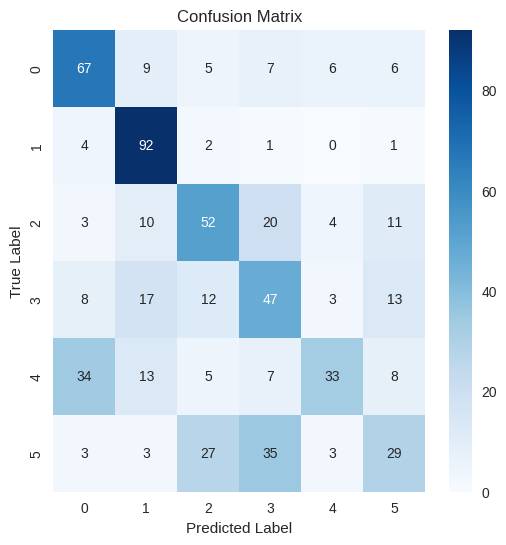

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [ ]:
# Save the final model
joblib.dump(best_rf, '/content/drive/MyDrive/preprocessed_data/final_rf_model.joblib')
print("Final model saved")

Final model saved


**XG Boost on feature set 1**

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load the PCA-transformed data
X_train_pca = np.load('/content/drive/MyDrive/preprocessed_data/X_train_pca.npy')
y_train = np.load('/content/drive/MyDrive/preprocessed_data/y_train.npy')
X_test_pca = np.load('/content/drive/MyDrive/preprocessed_data/X_test_pca.npy')
y_test = np.load('/content/drive/MyDrive/preprocessed_data/y_test.npy')

# Define the objective function for Optuna
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
    }

    xgb_model = xgb.XGBClassifier(**params, random_state=42)
    xgb_model.fit(X_train_pca, y_train)
    y_pred = xgb_model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the hyperparameters
print("Optimizing hyperparameters using Optuna...")
study.optimize(objective, n_trials=20)

# Print the best hyperparameters and best accuracy
print("Best hyperparameters:", study.best_params)

[I 2024-06-22 06:39:33,612] A new study created in memory with name: no-name-f57ff754-363a-47a8-b4d1-15fee2ae183c


Optimizing hyperparameters using Optuna...


[I 2024-06-22 06:42:38,944] Trial 0 finished with value: 0.54 and parameters: {'max_depth': 3, 'learning_rate': 0.014693308775809807, 'n_estimators': 262}. Best is trial 0 with value: 0.54.
[I 2024-06-22 06:49:20,785] Trial 1 finished with value: 0.5283333333333333 and parameters: {'max_depth': 4, 'learning_rate': 0.013163695258337648, 'n_estimators': 374}. Best is trial 0 with value: 0.54.
[I 2024-06-22 06:56:19,407] Trial 2 finished with value: 0.5366666666666666 and parameters: {'max_depth': 6, 'learning_rate': 0.1153535702650025, 'n_estimators': 424}. Best is trial 0 with value: 0.54.
[I 2024-06-22 07:10:25,751] Trial 3 finished with value: 0.5416666666666666 and parameters: {'max_depth': 10, 'learning_rate': 0.04909954150240642, 'n_estimators': 366}. Best is trial 3 with value: 0.5416666666666666.
[I 2024-06-22 07:19:09,223] Trial 4 finished with value: 0.5216666666666666 and parameters: {'max_depth': 4, 'learning_rate': 0.0037865015327454604, 'n_estimators': 490}. Best is trial 3

Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.07921526001032073, 'n_estimators': 431}


In [ ]:
# Train the XGBoost model with the best hyperparameters
best_xgb = xgb.XGBClassifier(**study.best_params, random_state=42)
best_xgb.fit(X_train_pca, y_train)

# Make predictions on the test set using the best model
y_pred = best_xgb.predict(X_test_pca)

# Calculate accuracy and other evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5517
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.70      0.66       100
           1       0.74      0.89      0.81       100
           2       0.48      0.63      0.54       100
           3       0.41      0.41      0.41       100
           4       0.63      0.42      0.50       100
           5       0.39      0.26      0.31       100

    accuracy                           0.55       600
   macro avg       0.54      0.55      0.54       600
weighted avg       0.54      0.55      0.54       600



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save the best model
joblib.dump(best_xgb, '/content/drive/MyDrive/preprocessed_data/xgb_model.joblib')

**Preprocessing and Modeling on Features Set 2**

Deep Features of VGG16 model


In [ ]:
import numpy as np
import os
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

def resize_and_standardize(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img


def extract_deep_features(image):
    model = VGG16(weights='imagenet', include_top=False)
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    img_resized = cv2.resize(image, (224, 224))
    img_array = np.expand_dims(img_resized, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()


In [ ]:
#taking only 500 imges from each class
def preprocess_dataset(data_dir, target_size=(150, 150), max_per_class=500):
    X = []
    y = []
    class_names = []

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_names.append(class_name)
            image_paths = [os.path.join(class_path, img_name) for img_name in os.listdir(class_path)
                           if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

            # If it's the Forest class and has more than max_per_class images, randomly sample max_per_class images
            if class_name == 'Forest' and len(image_paths) > max_per_class:
                image_paths = random.sample(image_paths, max_per_class)

            for img_path in tqdm(image_paths, desc=f"Processing {class_name}"):
                img = resize_and_standardize(img_path, target_size)
                features = extract_deep_features(img)
                X.append(features)
                y.append(class_names.index(class_name))

    X = np.array(X)
    y = np.array(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, class_names, scaler



In [ ]:
# Load the preprocessed dataset
X_train, X_test, y_train, y_test, class_names, scaler = preprocess_dataset(data_dir)


In [ ]:
print("Preprocessed dataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Preprocessed dataset shapes:
X_train: (2400, 25088)
X_test: (600, 25088)
y_train: (2400,)
y_test: (600,)


In [ ]:
import joblib
import os

# Directory to save the files
save_dir = "/content/drive/MyDrive/feat_2_data"
os.makedirs(save_dir, exist_ok=True)

# Save the datasets
joblib.dump(X_train, os.path.join(save_dir, 'X_train.pkl'))
joblib.dump(X_test, os.path.join(save_dir, 'X_test.pkl'))
joblib.dump(y_train, os.path.join(save_dir, 'y_train.pkl'))
joblib.dump(y_test, os.path.join(save_dir, 'y_test.pkl'))
joblib.dump(scaler, os.path.join(save_dir, 'scaler.pkl'))

print("All preprocessed data has been saved successfully.")


All preprocessed data has been saved successfully.


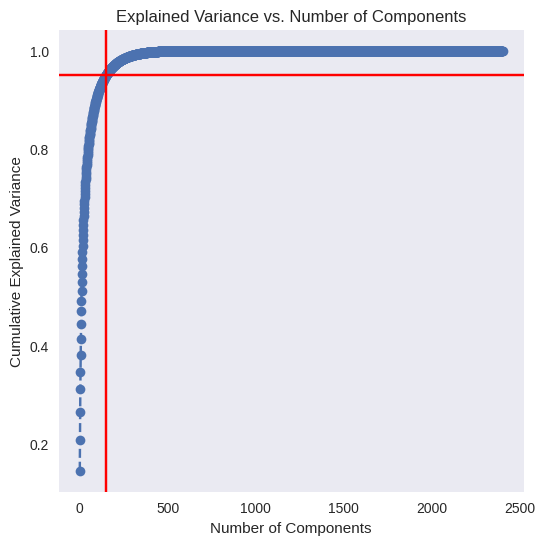

Optimal number of components to retain 95% variance: 150


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fit PCA to the training data
pca = PCA().fit(X_train)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance
plt.figure(figsize=(6, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=np.argmax(cumulative_explained_variance >= 0.95) + 1, color='r', linestyle='-')
plt.grid()
plt.show()

# Print the number of components needed to explain 95% variance
optimal_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Optimal number of components to retain 95% variance: {optimal_components}")


In [ ]:
# Fit PCA with the optimal number of components
optimal_pca = PCA(n_components=optimal_components)
X_train_pca = optimal_pca.fit_transform(X_train)
X_test_pca = optimal_pca.transform(X_test)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Number of features after PCA: {X_train_pca.shape[1]}")

Original number of features: 25088
Number of features after PCA: 150


In [ ]:
import numpy as np
import joblib
import os

# Define the directory to save the files
save_dir = "/content/drive/MyDrive/feat_2_data"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Save the PCA-transformed training data
np.save(os.path.join(save_dir, "X_train_pca.npy"), X_train_pca)
np.save(os.path.join(save_dir, "y_train.npy"), y_train)

# Save the PCA-transformed test data
np.save(os.path.join(save_dir, "X_test_pca.npy"), X_test_pca)
np.save(os.path.join(save_dir, "y_test.npy"), y_test)

# Save the PCA object itself
joblib.dump(optimal_pca, os.path.join(save_dir, "optimal_pca.pkl"))

print("PCA-transformed datasets and PCA object have been saved.")


PCA-transformed datasets and PCA object have been saved.


Xgboost model on feature set 2


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Define the objective function for Optuna
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
    }

    xgb_model = xgb.XGBClassifier(**params, random_state=42)
    xgb_model.fit(X_train_pca, y_train)
    y_pred = xgb_model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the hyperparameters
print("Optimizing hyperparameters using Optuna...")
study.optimize(objective, n_trials=20)

# Print the best hyperparameters and best accuracy
print("Best hyperparameters:", study.best_params)

[I 2024-06-22 20:21:59,792] A new study created in memory with name: no-name-f222a5e1-8a4f-46bd-b0b4-36cada7a3fd6


Optimizing hyperparameters using Optuna...


[I 2024-06-22 20:24:50,765] Trial 0 finished with value: 0.5316666666666666 and parameters: {'max_depth': 6, 'learning_rate': 0.002041265923142945, 'n_estimators': 397}. Best is trial 0 with value: 0.5316666666666666.
[I 2024-06-22 20:25:36,094] Trial 1 finished with value: 0.5983333333333334 and parameters: {'max_depth': 8, 'learning_rate': 0.09350051028869065, 'n_estimators': 97}. Best is trial 1 with value: 0.5983333333333334.
[I 2024-06-22 20:26:09,898] Trial 2 finished with value: 0.5283333333333333 and parameters: {'max_depth': 3, 'learning_rate': 0.0030572452335511672, 'n_estimators': 499}. Best is trial 1 with value: 0.5983333333333334.
[I 2024-06-22 20:28:22,527] Trial 3 finished with value: 0.5033333333333333 and parameters: {'max_depth': 8, 'learning_rate': 0.0020170987222172796, 'n_estimators': 170}. Best is trial 1 with value: 0.5983333333333334.
[I 2024-06-22 20:29:07,458] Trial 4 finished with value: 0.6 and parameters: {'max_depth': 10, 'learning_rate': 0.20120801541612

Best hyperparameters: {'max_depth': 13, 'learning_rate': 0.1851587465511226, 'n_estimators': 336}


In [ ]:
# Train the XGBoost model with the best hyperparameters
best_xgb = xgb.XGBClassifier(**study.best_params, random_state=42)
best_xgb.fit(X_train_pca, y_train)

# Make predictions on the test set using the best model
y_pred = best_xgb.predict(X_test_pca)

# Calculate accuracy and other evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6233
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       100
           1       0.77      0.85      0.81       100
           2       0.55      0.48      0.51       100
           3       0.54      0.52      0.53       100
           4       0.60      0.60      0.60       100
           5       0.59      0.62      0.60       100

    accuracy                           0.62       600
   macro avg       0.62      0.62      0.62       600
weighted avg       0.62      0.62      0.62       600



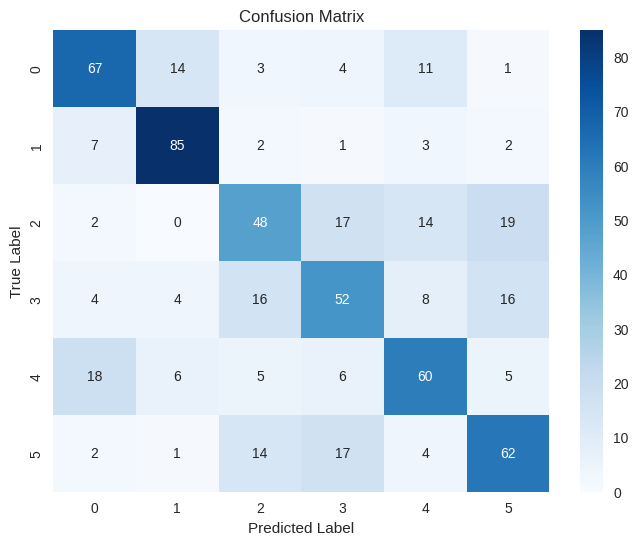

['/content/drive/MyDrive/feat_2_data/xgb_model_2.joblib']

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save the best model
joblib.dump(best_xgb, '/content/drive/MyDrive/feat_2_data/xgb_model_2.joblib')

Random Forest on feature set 2

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna
from scipy.stats import randint as sp_randint
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Define the parameter space
param_dist = {
    'n_estimators': sp_randint(100, 500),
    'max_depth': [None] + list(sp_randint(10, 100).rvs(10))
}

# Define the objective function for Optuna
def objective(trial):
    # Sample hyperparameters from the parameter space
    n_estimators = trial.suggest_int('n_estimators', param_dist['n_estimators'].a, param_dist['n_estimators'].b)
    max_depth = trial.suggest_categorical('max_depth', param_dist['max_depth'])

    # Create the Random Forest classifier with the sampled hyperparameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    # Fit the Random Forest classifier
    rf.fit(X_train_pca, y_train)
    # Make predictions on the test set
    y_pred = rf.predict(X_test_pca)
    # Calculate accuracy as the objective value
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the hyperparameters
print("Optimizing hyperparameters using Optuna...")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best hyperparameters:")
print(study.best_params)

[I 2024-06-22 21:01:41,372] A new study created in memory with name: no-name-f5b73a03-5212-4c2a-8e02-f295a8fc145d


Optimizing hyperparameters using Optuna...


[I 2024-06-22 21:01:54,919] Trial 0 finished with value: 0.58 and parameters: {'n_estimators': 305, 'max_depth': 60}. Best is trial 0 with value: 0.58.
[I 2024-06-22 21:02:04,827] Trial 1 finished with value: 0.5816666666666667 and parameters: {'n_estimators': 301, 'max_depth': 91}. Best is trial 1 with value: 0.5816666666666667.
[I 2024-06-22 21:02:11,750] Trial 2 finished with value: 0.5733333333333334 and parameters: {'n_estimators': 246, 'max_depth': 25}. Best is trial 1 with value: 0.5816666666666667.
[I 2024-06-22 21:02:28,301] Trial 3 finished with value: 0.5883333333333334 and parameters: {'n_estimators': 463, 'max_depth': 80}. Best is trial 3 with value: 0.5883333333333334.
[I 2024-06-22 21:02:35,612] Trial 4 finished with value: 0.5633333333333334 and parameters: {'n_estimators': 141, 'max_depth': 92}. Best is trial 3 with value: 0.5883333333333334.
[I 2024-06-22 21:02:59,269] Trial 5 finished with value: 0.585 and parameters: {'n_estimators': 478, 'max_depth': None}. Best is

Best hyperparameters:
{'n_estimators': 414, 'max_depth': 10}


In [ ]:
# # Train the final Random Forest model with the best parameters
best_rf = RandomForestClassifier(**study.best_params, random_state=42)
best_rf.fit(X_train_pca, y_train)

# Make predictions on the test set using the best model
y_pred = best_rf.predict(X_test_pca)

# Calculate accuracy and other evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5983
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       100
           1       0.76      0.83      0.79       100
           2       0.51      0.41      0.46       100
           3       0.47      0.52      0.50       100
           4       0.56      0.54      0.55       100
           5       0.57      0.56      0.56       100

    accuracy                           0.60       600
   macro avg       0.59      0.60      0.59       600
weighted avg       0.59      0.60      0.59       600



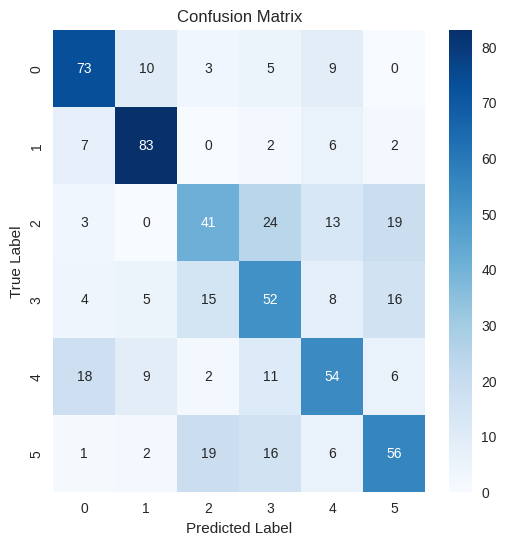

Final model saved


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save the model
joblib.dump(best_rf, '/content/drive/MyDrive/feat_2_data/rf_model_2.joblib')
print("Final model saved")

RESULT

In [4]:
import pandas as pd

# Create a DataFrame with the given data
data = {
    'Model': ['Random Forest (RF)', 'XGBoost (XGB)', 'Random Forest (RF)', 'XGBoost (XGB)'],
    'Features': ['HOG, Color Histogram, Haralick', 'HOG, Color Histogram, Haralick', 'Deep Features', 'Deep Features'],
    'Accuracy (%)': [53.33, 55.17, 59.83, 62.33]
}

df = pd.DataFrame(data)

# Highlight the row with the highest accuracy
def highlight_max_row(s):
    is_max = s == s.max()
    return ['background-color: grey' if v else '' for v in is_max]

# Apply the highlighting function to the DataFrame
styled_df = df.style.apply(highlight_max_row, subset=['Accuracy (%)'], axis=0)

styled_df


,Model,Features,Accuracy (%)
0,Random Forest (RF),"HOG, Color Histogram, Haralick",53.330000
1,XGBoost (XGB),"HOG, Color Histogram, Haralick",55.170000
2,Random Forest (RF),Deep Features,59.830000
3,XGBoost (XGB),Deep Features,62.330000


**Conclusion**


Image Preprocessing:
- Images were resized to a standard size:
  - 150x150 for feature set 1 (HOG, color histogram, Haralick texture features)
  - 224x224 for feature set 2 (VGG16 deep features)
- Image color space was converted from BGR to RGB
- Pixel values were normalized to the range [0, 1]
- Relevant features were extracted:
  - Feature set 1: HOG, color histogram, and Haralick texture features
  - Feature set 2: Deep features from the pre-trained VGG16 model
- Data was split into training and testing sets
- Feature values were standardized using StandardScaler

Feature Set Importance:
- HOG (Histogram of Oriented Gradients) features:
  - Capture edge and gradient structure of images
  - Provide information about the shape and texture of objects

- Color Histograms:
  - Represent the distribution of colors in the image
  - Useful for distinguishing scenes with different color profiles

- Haralick Texture Features:
  - Capture statistical properties of image texture
  - Computed from the Gray Level Co-occurrence Matrix (GLCM)
  - Provide information about the spatial arrangement of intensities

- Deep Features from VGG16:
  - Extracted from the pre-trained VGG16 convolutional neural network
  - Provide a high-level, semantic representation of the image content
  - Leverage the model's ability to detect complex visual patterns


Dimensionality Reduction:
- Principal Component Analysis (PCA) was used to reduce feature dimensionality
- Feature Set 1:
  - Original feature size: 125257
  - PCA reduced to 1199 components while retaining 90% of the variance

- Feature Set 2 (Deep Features):
  - Original feature size: 25088
  - PCA reduced to 150 components while preserving 95% of the variance

- Benefits of dimensionality reduction:
  - Avoids overfitting by removing redundant or noisy features
  - Reduces computational costs during training and inference
  - Can improve model accuracy by focusing on the most informative features

Model Evaluation:
- Accuracy: the primary metric, measures the percentage of correctly classified images
- Precision: the proportion of true positive predictions among all positive predictions
- Recall: the proportion of true positive predictions among all actual positive instances
- F1 Score: the harmonic mean of precision and recall, providing a balanced measure
- Confusion Matrices:
  - Visualize the distribution of predictions across classes
  - Help identify classes that are frequently confused with each other

Results Comparison:
- Deep features (Feature Set 2) outperformed the custom feature set (Feature Set 1)
  - Deep features capture high-level semantic information
  - More effective for distinguishing between scene categories

- XGBoost slightly outperformed Random Forest on both feature sets
  - XGBoost: 55.17% accuracy on Feature Set 1, 62.33% accuracy on Feature Set 2
  - Random Forest: 53.33% accuracy on Feature Set 1, 59.83% accuracy on Feature Set 2

- Both models performed competitively, suggesting the choice of features had a larger impact than the choice of model

Enhancement and Automation:
- Potential improvements:
  - Expand the training dataset to increase diversity and robustness
  - Fine-tune the deep feature extractor (VGG16) on the specific dataset
  - Explore ensemble methods combining multiple models or feature sets
  - We can use all the images from forest class and use data augmentation.

- Automating feature extraction:
  - Train deep learning models end-to-end directly on the images
  - Models learn to extract appropriate feature representations automatically
  - Eliminates the need for manual feature engineering



**Summary:**

The goal was to classify images into 6 categories: Streets, Forest, Sea, Glacier, Building, and Mountains. Two different feature sets were used:

HOG features, color histograms, and Haralick texture features.

Deep features extracted from a pre-trained VGG16 model.

The extracted features underwent dimensionality reduction using PCA.
Random Forest and XGBoost models were trained on each feature set, with hyperparameter tuning using Optuna. Model performance was evaluated using accuracy and other classification metrics.

The best performing model was XGBoost trained on the deep features, achieving 62.33% accuracy. Random Forest on deep features got 59.83% accuracy. The HOG+color histogram+texture feature set performed worse, with 55.17% accuracy for XGBoost and 53.33% for Random Forest.